## 用神经网络逼近任意函数
这个notebook展示了使用DeepXDE逼近任意函数。



1. [$y = a_n x^n + a_{n-1} x^{n-1}+ \dots + a_1 x + a_0$](#func1)
2. [$y = x \sin(ax+b)$](#func2)
3. [$y = e^x$](#func3)
4. [$y = \ln x$](#func4)
5. [$y = \tan x$](#func5)

### 基本初等函数

数学分析将基本初等函数归为六类：幂函数、指数函数、对数函数、三角函数、反三角函数、常数函数。

$$
\large
\begin{aligned}
&1. y = c, &&c \in \mathbb{R}, && x \in \mathbb{R}, &&y = c,\\
&2. y = x^{\alpha}, &&\alpha \in \mathbb{R},&& x \in \mathbb{R}, &&y \in \mathbb{R},\\
&3. y = a^x, &&a>0, a \neq 1, a \in \mathbb{R},&& x \in \mathbb{R}, &&y \in \mathbb{R},\\
&4. y = \log_a x, &&a>0, a \neq 1, a \in \mathbb{R}, && x \in (0, +\infty), &&y \in \mathbb{R},\\
\end{aligned}\\
\large
\begin{aligned}
&5. y=\sin x,&&y=\cos x,&&y=\tan x,&&y=\csc x,&&y=\sec x,&&y=\cot x,\\
&6. y=\arcsin x,&&y=\arccos x,&&y=\arctan x,&&y=\operatorname{arccsc}x,&&y=\operatorname{arcsec}x,&&y=\operatorname{arccot}x,\\
\end{aligned}\\
$$

### 初等函数
初等函数是由幂函数（power function）、指数函数（exponential function）、对数函数（logarithmic function）、三角函数（trigonometric function）、反三角函数（inverse trigonometric function）与常数经过有限次的有理运算（加、减、乘、除、有理数次乘方、有理数次开方）及有限次函数复合所产生，并且能用一个解析式表示的函数。

### 非初等函数

一般说来，大部分分段函数不是初等函数。如符号函数，狄利克雷函数，gamma函数，误差函数，Weierstrass函数。

In [24]:
# 绘图的辅助函数

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_loss_history(loss_history):
    """Plot the training and testing loss history.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        loss_history: ``LossHistory`` instance. The first variable returned from
            ``Model.train()``.
    """
    loss_train = np.sum(loss_history.loss_train, axis=1)
    loss_test = np.sum(loss_history.loss_test, axis=1)

    plt.figure(figsize=(10, 8))
    plt.semilogy(loss_history.steps, loss_train, label="Train loss")
    plt.semilogy(loss_history.steps, loss_test, label="Test loss")
    for i in range(len(loss_history.metrics_test[0])):
        plt.semilogy(
            loss_history.steps,
            np.array(loss_history.metrics_test)[:, i],
            label="Test metric",
        )
    plt.xlabel("Steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    


def _pack_data(train_state):
    def merge_values(values):
        if values is None:
            return None
        return np.hstack(values) if isinstance(values, (list, tuple)) else values

    y_train = merge_values(train_state.y_train)
    y_test = merge_values(train_state.y_test)
    best_y = merge_values(train_state.best_y)
    best_ystd = merge_values(train_state.best_ystd)
    return y_train, y_test, best_y, best_ystd

def plot_best_state(train_state):
    """Plot the best result of the smallest training loss.

    This function only works for 1D and 2D problems. For other problems and to better
    customize the figure, use ``save_best_state()``.

    Note:
        You need to call ``plt.show()`` to show the figure.

    Args:
        train_state: ``TrainState`` instance. The second variable returned from
            ``Model.train()``.
    """
    if isinstance(train_state.X_train, (list, tuple)):
        print(
            "Error: The network has multiple inputs, and plotting such result han't been implemented."
        )
        return

    y_train, y_test, best_y, best_ystd = _pack_data(train_state)
    y_dim = best_y.shape[1]

    # Regression plot
    # 1D
    if train_state.X_test.shape[1] == 1:
        idx = np.argsort(train_state.X_test[:, 0])
        X = train_state.X_test[idx, 0]
        plt.figure(figsize=(10, 6))
        for i in range(y_dim):
            if y_train is not None:
                plt.plot(train_state.X_train[:, 0], y_train[:, i], "ok", label="Train")
            if y_test is not None:
                plt.plot(X, y_test[idx, i], "-k", label="True")
            plt.plot(X, best_y[idx, i], "--r", label="Prediction")
            if best_ystd is not None:
                plt.plot(
                    X, best_y[idx, i] + 2 * best_ystd[idx, i], "-b", label="95% CI"
                )
                plt.plot(X, best_y[idx, i] - 2 * best_ystd[idx, i], "-b")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
    # 2D
    elif train_state.X_test.shape[1] == 2:
        for i in range(y_dim):
            plt.figure(figsize=(20, 12))
            ax = plt.axes(projection=Axes3D.name)
            ax.plot3D(
                train_state.X_test[:, 0],
                train_state.X_test[:, 1],
                best_y[:, i],
                ".",
            )
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")
            ax.set_zlabel("$y_{}$".format(i + 1))

    plt.show()

 “uniform” (equispaced grid), “pseudo” (pseudorandom), “LHS” (Latin hypercube sampling), “Halton” (Halton sequence), “Hammersley” (Hammersley sequence), or “Sobol” (Sobol sequence).

**归一化**

$\large x\in [0,n],\to  , 令 y = \frac{x}{n}，则y \in [0,1]$

$\large x\in [a,b],\to  , 令 y = \frac{x-a}{b-a}，则y \in [0,1]$

**反归一化**

$\large x\in [0,1],\to  , 令 y = n x，则y \in [0,n]$

$\large x\in [0,1],\to  , 令 y = (b-a)x + a，则y \in [a,b]$

In [151]:
import deepxde as dde
import numpy as np

# def func(x):
#     """
#     x: array_like, N x D_in
#     y: array_like, N x D_out
#     """
#     return scale*x * np.sin(5 *scale* x)

def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    x = scale*x
    return x * np.sin(5 * x)

scale = 10
# geom = dde.geometry.Interval(-1.2, 1.2)
# geom = dde.geometry.Interval(-1., 1.)
geom = dde.geometry.Interval(0., 1.)

num_train = 200*scale
num_test = 100*scale
data = dde.data.Function(geom, func, num_train, num_test, train_distribution='pseudo', online=False)

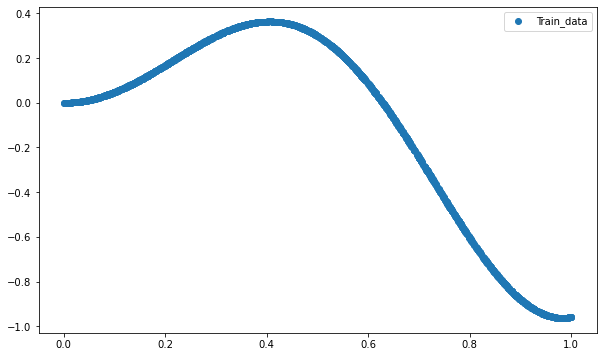

In [152]:
t_list = data.train_next_batch()[0].flatten()
train_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.scatter(t_list,train_data, label="Train_data")
plt.legend()

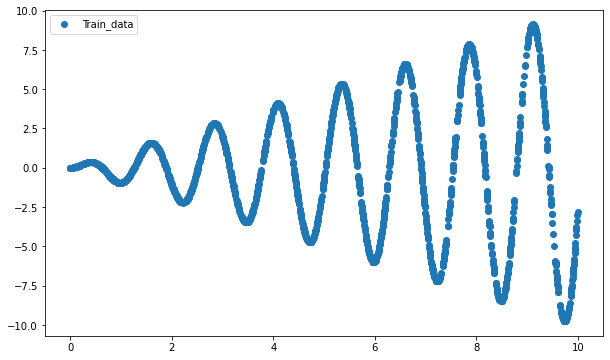

In [150]:
t_list = data.train_next_batch()[0].flatten()
train_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.scatter(t_list*scale,train_data, label="Train_data")
plt.legend()

In [131]:
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [100] * 10 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=2e-4, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=15000)

Compiling model...
Building feed-forward neural network...
'build' took 0.136226 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.002488 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [1.68e+01]    [1.69e+01]    [1.00e+00]    
1000      [1.65e+01]    [1.65e+01]    [9.88e-01]    
2000      [1.65e+01]    [1.65e+01]    [9.88e-01]    
3000      [1.65e+01]    [1.65e+01]    [9.89e-01]    
4000      [1.67e+01]    [1.68e+01]    [9.97e-01]    
5000      [1.67e+01]    [1.68e+01]    [9.98e-01]    
6000      [1.67e+01]    [1.69e+01]    [9.99e-01]    
7000      [1.67e+01]    [1.69e+01]    [9.99e-01]    
8000      [9.35e+00]    [1.00e+01]    [7.70e-01]    
9000      [2.16e-01]    [2.44e-01]    [1.20e-01]    
10000     [6.89e-02]    [7.58e-02]    [6.70e-02]    
11000     [1.19e-01]    [1.24e-01]    [8.56e-02]    
12000     [4.99e-02]    [5.09e-02]    [5.49e-02]    
13000     [2.14e-02]    [2.20e-02]    [3.61e-02]    
14000     [3.27e-03]    [3.72e-03]    [1.48e-02]    
15000     [4.37e-02]    [4.55e-02]    [5.19e-02]    

Best model at step 14000:


In [133]:
pre_data = model.predict(t_list)*scale
true_data = func(t_list)*scale

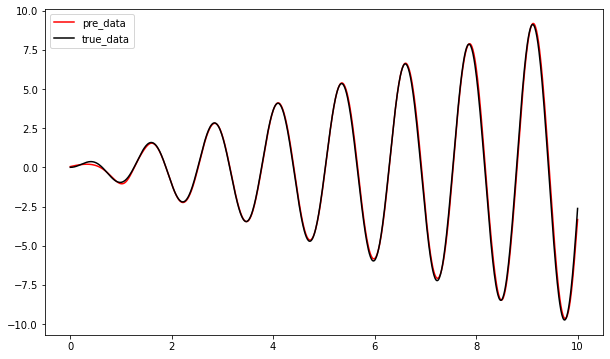

In [136]:
t_list = data.test()[0]

pre_data = model.predict(t_list)
true_data = func(t_list)

plt.figure(figsize=(10, 6))
plt.plot(t_list*scale, pre_data[:,0], "-r", label="pre_data")
plt.plot(t_list*scale, true_data[:,0], "-k", label="true_data")
plt.legend()

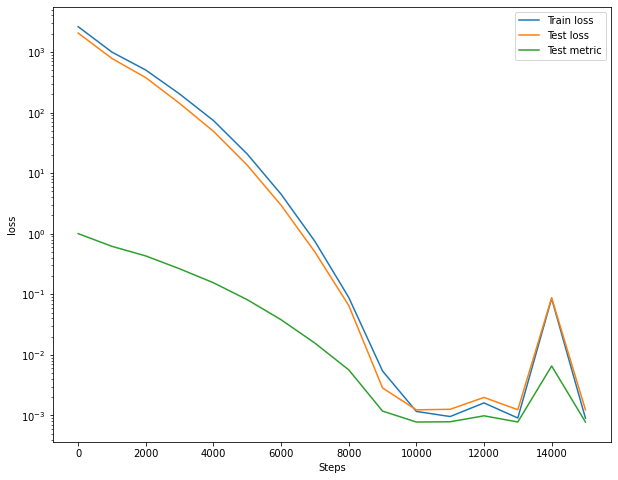

In [100]:
plot_loss_history(losshistory)

## 问题设置

我们将用神经网络逼近一个函数：

$$y = x \sin(5 x), \,\,\,\, x\in [-1,1]$$




源码：

https://github.com/lululxvi/deepxde/blob/master/examples/function/func.py

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax"""
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
def func(x):
    """
    x: array_like, N x D_in
    y: array_like, N x D_out
    """
    return x * np.sin(5 * x)


geom = dde.geometry.Interval(-1, 1)
num_train = 16
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test)

In [3]:
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [20] * 3 + [1], activation, initializer)

In [4]:
model = dde.Model(data, net)
model.compile("adam", lr=2e-4, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.068177 s



G:\Anaconda3\envs\py3.8\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
G:\Anaconda3\envs\py3.8\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 0.666008 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [3.35e-01]    [2.91e-01]    [1.18e+00]    
1000      [4.98e-02]    [5.16e-02]    [4.97e-01]    
2000      [3.64e-02]    [3.86e-02]    [4.30e-01]    
3000      [1.07e-03]    [8.39e-04]    [6.34e-02]    
4000      [2.97e-04]    [2.78e-04]    [3.65e-02]    
5000      [1.13e-04]    [1.37e-04]    [2.56e-02]    
6000      [4.98e-05]    [8.65e-05]    [2.04e-02]    
7000      [2.06e-05]    [5.87e-05]    [1.68e-02]    
8000      [8.30e-06]    [4.42e-05]    [1.45e-02]    
9000      [4.15e-06]    [3.66e-05]    [1.32e-02]    
10000     [2.26e-06]    [3.18e-05]    [1.23e-02]    
11000     [1.28e-06]    [2.80e-05]    [1.16e-02]    
12000     [1.70e-06]    [2.80e-05]    [1.16e-02]    
13000     [4.04e-07]    [2.41e-05]    [1.07e-02]    
14000     [1.91e-07]    [2.24e-05]    [1.04e-02]    
15000     [1.00e-07]    [2.15e-05]    [1.01e-02]    
16000     [5.52e-08]    [2.

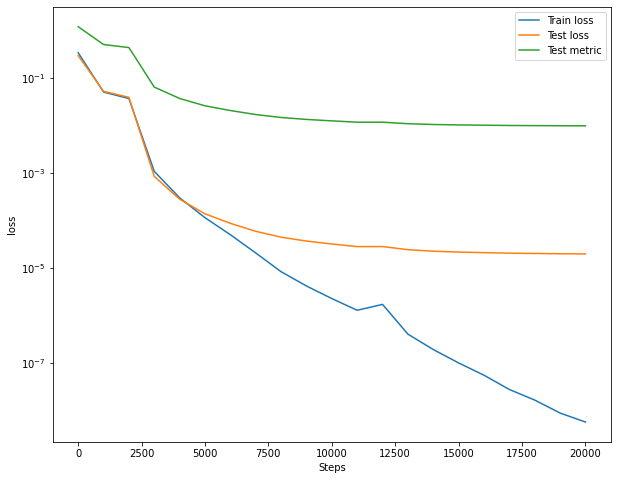

In [6]:
plot_loss_history(losshistory)

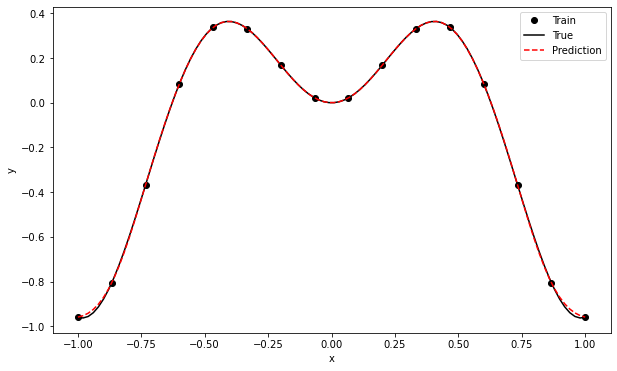

In [8]:
plot_best_state(train_state)

我们看到在边界上(x=1或-1附近)拟合的不是特别好，但是如果采样点取多一些，情况会变好。

## 学到更多

https://deepxde.readthedocs.io/en/latest/demos/function.html

### 函数逼近演示

下面是一些学习功能的演示。

#### 函数逼近

- [从数据集中学习函数](https://github.com/lululxvi/deepxde/blob/master/examples/function/dataset.py)
- [从公式中学习一个函数](https://github.com/lululxvi/deepxde/blob/master/examples/function/func.py)

#### 不确定性量化

- [学习具有不确定性量化的函数](https://github.com/lululxvi/deepxde/blob/master/examples/function/func_uncertainty.py)

#### 多保真学习

- [从公式中进行多保真学习](https://github.com/lululxvi/deepxde/blob/master/examples/function/mf_func.py)
- [从数据集中进行多保真学习](https://github.com/lululxvi/deepxde/blob/master/examples/function/mf_dataset.py)